In [1]:
#I like my cells wide and proud
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Review the resources landscape:
```
!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import xrange
import logging
import os
###########################
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_test, model_eval, tf_model_load
# from cleverhans_tutorials.tutorial_models import make_basic_cnn
########### keras ############
from cleverhans.utils_keras import cnn_model as cnn_keras
from cleverhans.utils_keras import KerasModelWrapper

Using TensorFlow backend.


In [3]:
import tensorflow as tf
print(tf.__version__)
import cleverhans
cleverhans.__version__

1.2.1


'2.0.0-7f7f9b18a1988fdf6d37d5c40deabae6'

# Initialize the parameters as per:
https://github.com/tensorflow/cleverhans/blob/b8d15f3d7b6f820f812087512b60d9675cb431eb/cleverhans_tutorials/mnist_tutorial_cw.py

In [4]:
#     :param train_start: index of first training set example
#     :param train_end: index of last training set example
#     :param test_start: index of first test set example
#     :param test_end: index of last test set example
#     :param viz_enabled: (boolean) activate plots of adversarial examples
#     :param nb_epochs: number of epochs to train model
#     :param batch_size: size of training batches
#     :param nb_classes: number of output classes
#     :param source_samples: number of test inputs to attack
#     :param learning_rate: learning rate for training
#     :param model_path: path to the model file
#     :param targeted: should we run a targeted attack? or untargeted?
train_start=0
train_end=60000
test_start=0
test_end=10000
viz_enabled=True
nb_epochs=6
batch_size=128
nb_classes=10
source_samples=10
learning_rate=0.001
attack_iterations=100
model_path=os.path.join("keras_models_tested_final", "mnist")
targeted=True
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Model definition:

In [5]:
# MNIST-specific dimensions
img_rows = 28
img_cols = 28
channels = 1

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# # Create TF session
# tf.device("/gpu:0")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.666), 
                                                 device_count={'CPU':2, 'GPU':1}))
print("Created TensorFlow session.")
import keras
from keras import backend as K
K.set_session(sess)
set_log_level(logging.DEBUG)

# Get MNIST test data
X_test, Y_test, X_test, Y_test = data_mnist(train_start=train_start,
                                              train_end=train_end,
                                              test_start=test_start,
                                              test_end=test_end)


# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

#################################################################################
# def make_basic_cnn(nb_filters=64, nb_classes=10,
#                    input_shape=(None, 28, 28, 1)):
#     layers = [Conv2D(nb_filters, (8, 8), (2, 2), "SAME"),
#               ReLU(),
#               Conv2D(nb_filters * 2, (6, 6), (2, 2), "VALID"),
#               ReLU(),
#               Conv2D(nb_filters * 2, (5, 5), (1, 1), "VALID"),
#               ReLU(),
#               Flatten(),
#               Linear(nb_classes),
#               Softmax()]

#     model = MLP(layers, input_shape)
#     return model

##################################################################################

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

nb_filters=64
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=(8, 8),strides=(2,2),padding="same",activation='relu',
                 input_shape=(img_rows, img_cols,channels)))
model.add(Conv2D(nb_filters*2, kernel_size=(6, 6),strides=(2,2),padding="valid",activation='relu'))
model.add(Conv2D(nb_filters*2, kernel_size=(5, 5),strides=(1,1),padding="valid",activation='relu'))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))

##################################################################################
preds = model(x)
print("Not yet Defined TensorFlow model graph.")


Created TensorFlow session.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
Not yet Defined TensorFlow model graph.


In [6]:
print(model_path)
print(os.path.exists(model_path + ".meta"))

rng = np.random.RandomState([2017, 11, 3])
# check if we've trained before, and if we have, use that pre-trained model
if os.path.exists(model_path + ".meta"):
    print('Loading the pre-trained Keras model')
    tf_model_load(sess, model_path)


keras_models_trained_final/mnist
True
Loading the pre-trained Keras model
INFO:tensorflow:Restoring parameters from keras_models_trained_final/mnist


###########################################################################
# Testing the loaded model using TensorFlow
###########################################################################

In [7]:
# Evaluate the accuracy of the MNIST model on legitimate test examples
eval_params = {'batch_size': 128}
accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
assert X_test.shape[0] == test_end - test_start, X_test.shape
print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
report.clean_test_clean_eval = accuracy

Test accuracy on legitimate test examples: 0.9868


In [8]:
model.load_weights('mnist_9868.h5')
model.predict_classes(X_test[0:6,:,:,:])

6/6 [==============================] - 0s


array([7, 2, 1, 0, 4, 1])

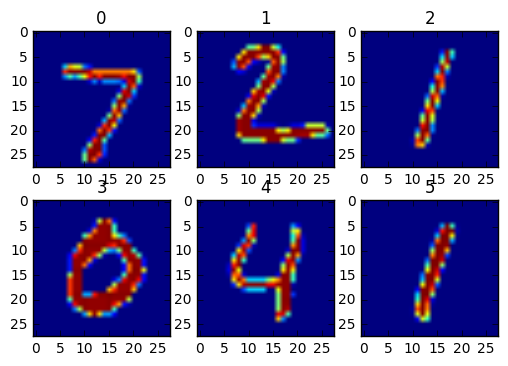

In [10]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[i,:,:,0])
    plt.title(str(i))

# Let's pick 10 legit examples to target:

Crafting 10 * 9 adversarial examples


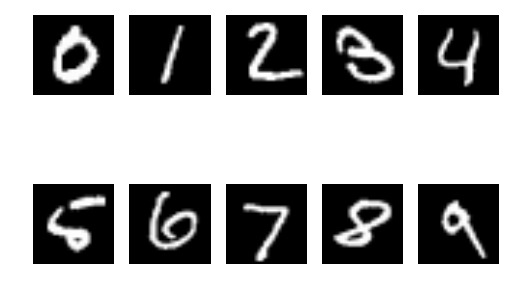

In [9]:
nb_adv_per_sample = str(nb_classes - 1)
print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample + ' adversarial examples')
###########################################################################

assert source_samples == nb_classes
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]
# [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
# Pick the first appearances of the 9 numbers in X_test
for i,idx in enumerate(idxs):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,:,:,0],cmap='gray')
    plt.axis('off')


# Create adv samples using the Carlini-L2 attack:

In [38]:
# Form a 10 x 10 array of the inputs that you seek to target:
adv_inputs = np.array([[instance] * nb_classes for instance in X_test[idxs]],dtype=np.float32)
adv_inputs = adv_inputs.reshape((source_samples * nb_classes, img_rows, img_cols, 1))


one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1



adv_ys = np.array([one_hot] * source_samples,dtype=np.float32).reshape((source_samples * nb_classes, nb_classes))
# yname = "y_target"
# Instantiate a CW attack object
# model_wrap = KerasModelWrapper(model)
cw = CarliniWagnerL2(model, back='tf', sess=sess)
cw_params = {'binary_search_steps': 15,
             'y_target': adv_ys,
             'max_iterations': 50000,
             'learning_rate': 1.5,
             'batch_size': source_samples * nb_classes if
             targeted else source_samples,
             'initial_const': 1,}

adv = cw.generate_np(adv_inputs, **cw_params)

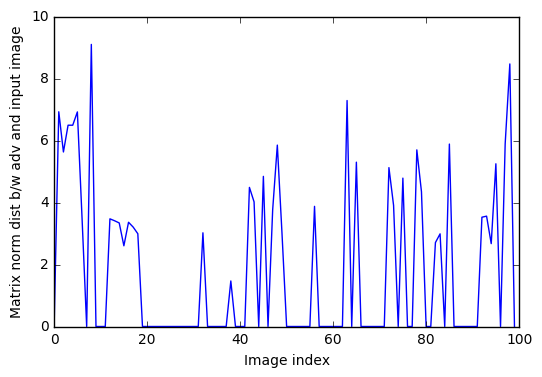

In [19]:
dev=np.zeros(100)
for i in range(100):
    dev[i]=np.linalg.norm(np.abs(adv[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [20]:
np.mod(np.where(dev>0.1)[0],10)

array([1, 2, 3, 4, 5, 6, 8, 2, 3, 4, 5, 6, 7, 8, 2, 8, 2, 3, 5, 7, 8, 9, 6,
       3, 5, 2, 3, 5, 8, 9, 2, 3, 5, 2, 3, 4, 5, 7, 8])

In [21]:
model.predict_classes(adv[np.where(dev>0.1)[0]])

32/39 [=======================>......] - ETA: 0s

array([1, 2, 3, 4, 5, 6, 8, 2, 3, 4, 5, 6, 7, 8, 2, 8, 2, 3, 5, 7, 8, 9, 6,
       3, 5, 2, 3, 5, 8, 9, 2, 3, 5, 2, 3, 4, 5, 7, 8])

In [23]:
np.save('adv_cw_targeted49_model9868.npy',adv)

# Non-targeted:

In [25]:
np.where(dev>0.1)[0]
y_test=np.where(Y_test==1)[1]
adv_inputs=np.zeros((100,28,28,1))
for i in range(10):
    ind_i=np.where(y_test==i)[0][0:10]
    adv_inputs[10*i:10*i+10,:,:,:]=X_test[ind_i]

cw = CarliniWagnerL2(model, back='tf', sess=sess)
cw_params = {'binary_search_steps': 10,
             'y_target': None,
             'max_iterations':10000,
             'learning_rate': 2,
             'batch_size':source_samples,
             'initial_const': 50,
            'clip_min' :0,
            'clip_max':1}

adv_nt = cw.generate_np(adv_inputs, **cw_params)

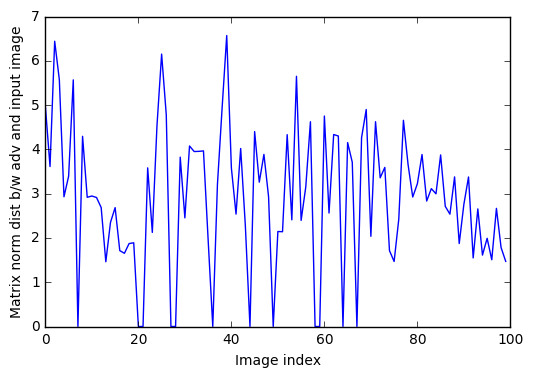

In [26]:
dev_nt=np.zeros(100)
for i in range(100):
    dev_nt[i]=np.linalg.norm(np.abs(adv_nt[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev_nt)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [30]:
len(np.where(dev_nt<0.01)[0])

12

In [32]:
model.predict_classes(adv_inputs)

 32/100 [========>.....................] - ETA: 0s

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9,
       9, 9, 9, 9, 5, 9, 9, 9])

In [35]:
model.predict_classes(adv_nt)

 32/100 [========>.....................] - ETA: 0s

array([6, 2, 6, 6, 2, 2, 6, 0, 6, 2, 8, 4, 8, 8, 8, 8, 8, 8, 8, 2, 2, 2, 3,
       4, 1, 3, 3, 2, 2, 8, 8, 5, 5, 5, 8, 2, 3, 5, 7, 8, 9, 8, 7, 7, 4, 2,
       7, 9, 9, 4, 6, 3, 6, 8, 9, 8, 7, 3, 5, 5, 5, 5, 4, 5, 6, 8, 5, 6, 5,
       5, 3, 2, 9, 2, 7, 7, 3, 3, 3, 3, 2, 6, 3, 3, 3, 3, 3, 2, 2, 3, 4, 4,
       4, 7, 7, 4, 9, 8, 4, 4])

In [36]:
(model.predict_classes(adv_nt)==model.predict_classes(adv_inputs)).sum()

 32/100 [========>.....................] - ETA: 0s

12

In [31]:
np.save('adv_cw_nontargeted88_model9868.npy',adv_nt)

# F-MNIST transfer learning here:

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         409728    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 710,218
Trainable params: 710,218
Non-trainable params: 0
_________________________________________________________________


#  Fashion-MNIST dataset:

## Label	Description :
 - 0:	T-shirt/top
 - 1	Trouser
 - 2	Pullover
 - 3	Dress
 - 4	Coat
 - 5	trouser
 - 6	Shirt
 - 7	tshirt
 - 8	Bag
 - 9	Ankle boot
 
 
 Source: github.com/zalandoresearch/fashion-mnist

2


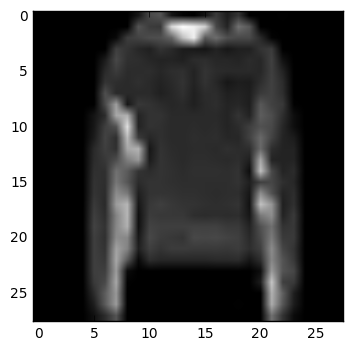

In [41]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(),'fashion_mnist'))
from utils import mnist_reader
X_test_vec, y_test_vec = mnist_reader.load_mnist('data/fashion', kind='train')
X_test_vec, y_test_vec = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_test_vec = X_test_vec.astype('float32')
X_test_vec = X_test_vec.astype('float32')
X_test_vec /= 255
X_test_vec /= 255
from keras.utils import np_utils
X_test_f=X_test_vec.reshape(60000,28,28,1)
X_test_f=X_test_vec.reshape(10000,28,28,1)
Y_test_f=np_utils.to_categorical(y_test_vec, num_classes=10)
Y_test_f=np_utils.to_categorical(y_test_vec, num_classes=10)
#Let's display a tshirt:

%matplotlib inline
plt.imshow(X_test_f[243,:,:,0],cmap='gray')
print(np.argmax(Y_test_f[243]))
nb_classes=10

In [ ]:
from sklearn.manifold import TSNE

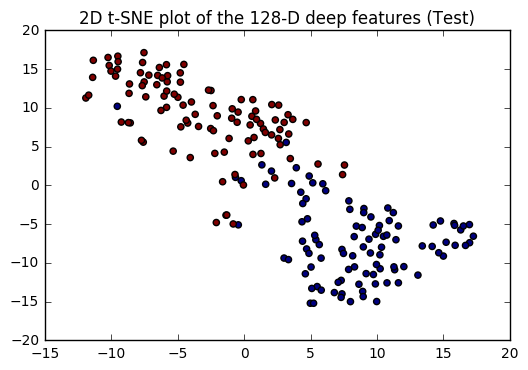

In [197]:
ind_tshirt=np.where(y_test_vec==0)[0][0:600]
ind_trouser=np.where(y_test_vec==1)[0][0:600]
X_tshirt=X_test_f[ind_tshirt]
X_trouser=X_test_f[ind_trouser]
X_tshirt_test=X_tshirt[0:500]
X_trouser_test=X_trouser[0:500]
X_tshirt_test=X_tshirt[500:]
X_trouser_test=X_trouser[500:]
X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])
X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])

get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[3].output])
X_tt_test_feat=get_3rd_layer_output([X_tt_test, 0])[0]
X_tt_embedded_test = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat)
y_tt_test=np.zeros(1000)
y_tt_test[500:]=1
plt.scatter(X_tt_embedded_test[:,0],X_tt_embedded_test[:,1],c=y_tt_test)
plt.title('2D t-SNE plot of the 128-D deep features (Test)')

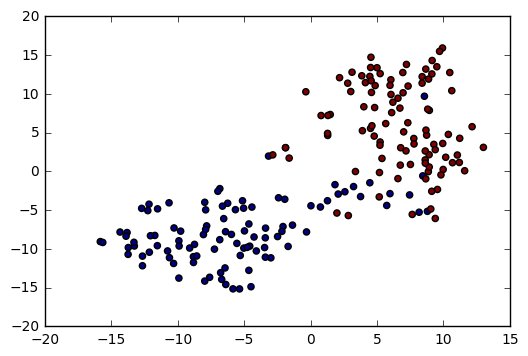

In [101]:
ind_tshirt=np.where(y_test_vec==0)[0][0:600]
ind_trouser=np.where(y_test_vec==1)[0][0:600]
X_tshirt=X_test_f[ind_tshirt]
X_trouser=X_test_f[ind_trouser]
X_tshirt_test=X_tshirt[0:500]
X_trouser_test=X_trouser[0:500]
X_tshirt_test=X_tshirt[500:]
X_trouser_test=X_trouser[500:]
X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])
X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])

get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[3].output])
X_tt_test_feat=get_3rd_layer_output([X_tt_test, 0])[0]
X_tt_embedded_test = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat)
y_tt_test=np.zeros(200)
y_tt_test[100:]=1
plt.scatter(X_tt_embedded_test[:,0],X_tt_embedded_test[:,1],c=y_tt_test)
plt.title('2D t-SNE plot of the 128-D deep features (Test dataset)')
plt.show()

In [200]:
X_tt_test_feat[:,0]

array([  1.00211608e+00,   2.27560759e+00,   1.14334226e+00,
         3.73541236e-01,   1.41179645e+00,   1.11836040e+00,
         0.00000000e+00,   0.00000000e+00,   2.08103135e-01,
         0.00000000e+00,   4.79357719e-01,   1.30666649e+00,
         1.13503623e+00,   4.66416895e-01,   9.06915545e-01,
         1.61475405e-01,   1.07114851e+00,   4.97307092e-01,
         1.39535511e+00,   2.60022640e+00,   4.30916041e-01,
         2.79621899e-01,   4.03635204e-05,   0.00000000e+00,
         7.26938665e-01,   1.94449499e-01,   3.34148109e-01,
         2.07435131e+00,   2.34667826e+00,   1.08449018e+00,
         6.46846950e-01,   6.16124690e-01,   3.40977572e-02,
         1.25438046e+00,   1.08411872e+00,   0.00000000e+00,
         6.47291005e-01,   4.48475391e-01,   8.18426758e-02,
         1.25172687e+00,   1.18895376e+00,   7.49930143e-01,
         1.13376570e+00,   6.75387681e-01,   1.72198504e-01,
         1.66633499e+00,   7.56329954e-01,   1.32074666e+00,
         2.13436389e+00,

In [177]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='linear')
clf.fit(X_tt_test_feat, y_tt_test) 
y_pred_svc=clf.predict(X_tt_test_feat)
confusion_matrix(y_tt_test, y_pred_svc)

array([[100,   0],
       [  0, 100]])

 32/600 [>.............................] - ETA: 0s

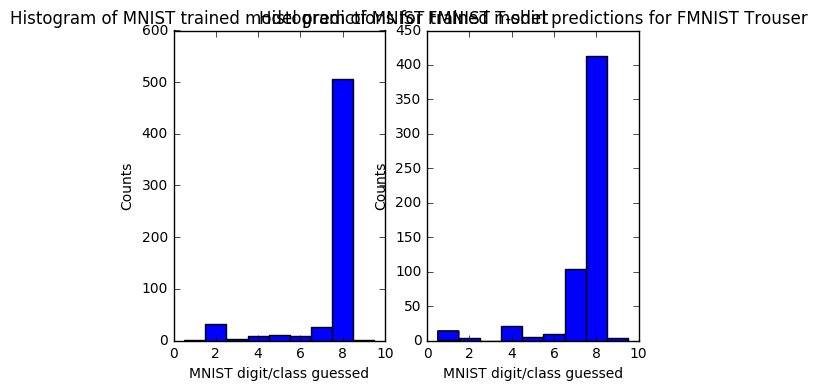

In [198]:
plt.figure(12,4)
plt.subplot(121)
plt.hist(model.predict_classes(X_tshirt),bins=np.arange(0.5,10.5))
plt.xlabel('MNIST digit/class guessed')
plt.ylabel('Counts')
plt.subplot(122)
plt.hist(model.predict_classes(X_trouser),bins=np.arange(0.5,10.5))
plt.xlabel('MNIST digit/class guessed')
plt.suptitle('Histogram of MNIST trained model predictions for FMNIST Trouser')
plt.ylabel('Counts')

In [122]:
model.predict_classes(X_test[0:6,:,:,:])

6/6 [==============================] - 0s


array([7, 2, 1, 0, 4, 1])

In [156]:
X_tt_test.shape

(200, 28, 28, 1)

(-0.5, 27.5, 27.5, -0.5)

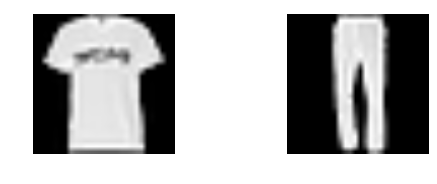

In [203]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[141,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test[41,:,:,0],cmap='gray')
plt.axis('off')

# Generate un-targeted adversarial examples for the 2-class FMNIST problem:

In [159]:
cw = CarliniWagnerL2(model, back='tf', sess=sess)
cw_params = {'binary_search_steps': 1,
             'y_target': None,
             'max_iterations':10000,
             'learning_rate': 0.9,
             'batch_size':1000,
             'initial_const':0.5,
            'clip_min' :0,
            'clip_max':1}

X_tt_test_adv = cw.generate_np(X_tt_test, **cw_params)
cw = CarliniWagnerL2(model, back='tf', sess=sess)
cw_params = {'binary_search_steps': 1,
             'y_target': None,
             'max_iterations':10000,
             'learning_rate': 0.9,
             'batch_size':200,
             'initial_const':0.5,
            'clip_min' :0,
            'clip_max':1}
X_tt_test_adv = cw.generate_np(X_tt_test, **cw_params)

[INFO 2017-11-05 19:15:12,044 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2017-11-05 19:15:12,742 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2017-11-05 19:15:12,808 cleverhans]   Binary search step 0 of 1
[DEBUG 2017-11-05 19:15:12,897 cleverhans]     Iteration 0 of 10000: loss=269 l2=0 f=0.1
[DEBUG 2017-11-05 19:15:32,370 cleverhans]     Iteration 1000 of 10000: loss=340 l2=0.199 f=0.1
[DEBUG 2017-11-05 19:15:32,371 cleverhans]     Failed to make progress; stop early
[DEBUG 2017-11-05 19:15:32,376 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2017-11-05 19:15:32,377 cleverhans]    Mean successful distortion: 1.101
[INFO 2017-11-05 19:15:32,380 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2017-11-05 19:15:32,818 cleverhans] Running CWL2 attack on instance 0 of 200
[DEBUG 2017-11-05 19:15:32,851 cleverhans]   Binary search step 0 of 1
[DEBUG 2017-11-05 19:15:32,917 cleverhans

(-0.5, 27.5, 27.5, -0.5)

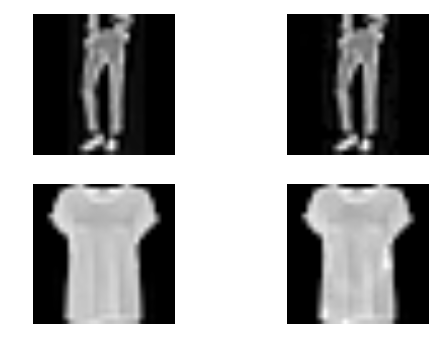

In [160]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[243,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test_adv[243,:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(X_tt_test[543,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(X_tt_test_adv[543,:,:,0],cmap='gray')
plt.axis('off')

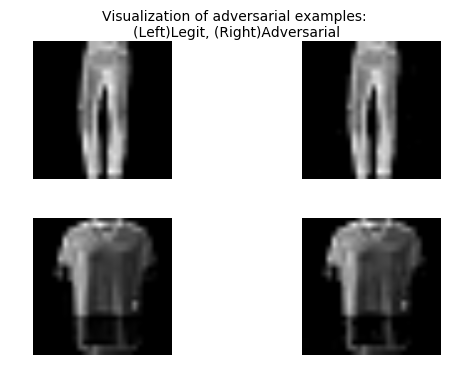

In [195]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[43,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test_adv[43,:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(X_tt_test[143,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(X_tt_test_adv[143,:,:,0],cmap='gray')
plt.axis('off')
plt.suptitle('Visualization of adversarial examples: \n(Left)Legit, (Right)Adversarial')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Confirming that the damage is indeed done

In [166]:

(model.predict_classes(X_tt_train)==model.predict_classes(X_tt_train_adv)).sum()

 896/1000 [=========================>....] - ETA: 0s

0

In [167]:
(model.predict_classes(X_tt_test)==model.predict_classes(X_tt_test_adv)).sum()

 32/200 [===>..........................] - ETA: 0s

0

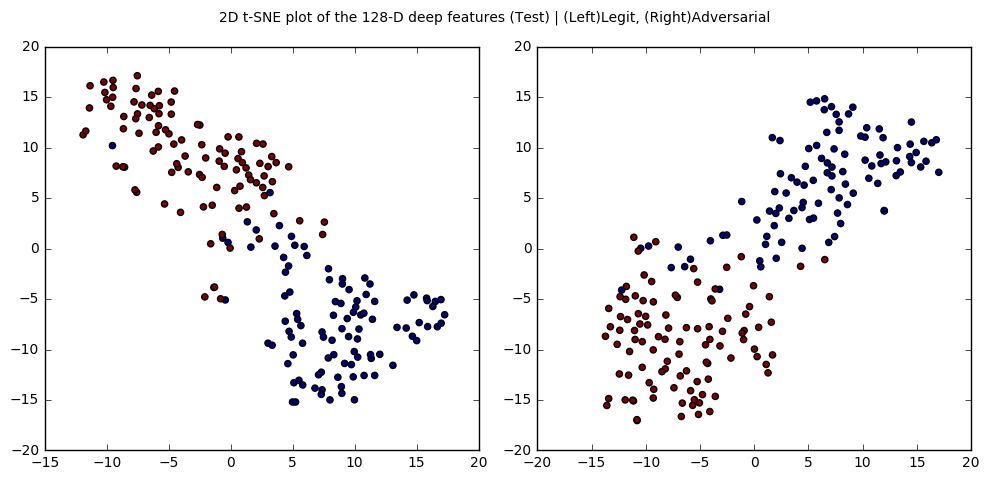

In [194]:
# X_tt_test_feat=get_3rd_layer_output([X_tt_test, 0])[0]
# X_tt_embedded_test = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat)
# y_tt_test=np.zeros(200)
# y_tt_test[100:]=1
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X_tt_embedded_test[:,0],X_tt_embedded_test[:,1],c=y_tt_test)



# X_tt_test_feat_adv=get_3rd_layer_output([X_tt_test_adv, 0])[0]
# X_tt_embedded_test_adv = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat_adv)
# y_tt_test=np.zeros(200)
# y_tt_test[100:]=1
plt.subplot(122)
plt.scatter(X_tt_embedded_test_adv[:,0],X_tt_embedded_test_adv[:,1],c=y_tt_test)

plt.suptitle('2D t-SNE plot of the 128-D deep features (Test) | (Left)Legit, (Right)Adversarial')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [184]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')
clf.fit(X_tt_test_feat, y_tt_test) 
y_pred_svc=clf.predict(X_tt_test_feat)
print(confusion_matrix(y_tt_test, y_pred_svc))

clf = SVC( kernel='linear')
clf.fit(X_tt_test_feat, y_tt_test) 
y_pred_svc=clf.predict(X_tt_test_feat)
confusion_matrix(y_tt_test, y_pred_svc)

[[ 93   7]
 [  0 100]]


array([[100,   0],
       [  0, 100]])

In [186]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')
clf.fit(X_tt_test_feat_adv, y_tt_test) 
y_pred_svc=clf.predict(X_tt_test_feat_adv)
print(confusion_matrix(y_tt_test, y_pred_svc))

clf = SVC( kernel='linear')
clf.fit(X_tt_test_feat_adv, y_tt_test) 
y_pred_svc=clf.predict(X_tt_test_feat_adv)
confusion_matrix(y_tt_test, y_pred_svc)

[[ 92   8]
 [  0 100]]


array([[100,   0],
       [  0, 100]])

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))